In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import bolift
from langchain.prompts.prompt import PromptTemplate

MODEL = "text-curie-001"

np.random.seed(0)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request


urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

## BayesOpt experiments

In [6]:
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment(
    asktell, raw_data, indexes, x_name, y_name, N=10, aq="random", start_index=0
):
    for i in indexes[:N]:
        # asktell.tell(raw_data.iloc[i, 0], float(raw_data.iloc[i, 1]))
        asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))

    # x = [raw_data.iloc[i, 0] for i in indexes]
    x = [raw_data[x_name].iloc[i] for i in indexes]

    pool = bolift.Pool(list(x), formatter=asktell.format_x)
    # start low
    # xi = x[np.random.choice(25, 1)[0]]
    xi = x[start_index]
    pool.choose(xi)
    # give one point
    yi = float(raw_data[raw_data[x_name] == xi][y_name])
    asktell.tell(xi, yi)
    point = [(xi, yi)]
    best = point[0][1]
    for i in range(N):
        if i == N - 1 and aq != "random":
            aq = "greedy"
        px, _, py = asktell.ask(pool, k=1, aq_fxn=aq)
        xc = px[0]
        # print(xc)
        pool.choose(xc)
        y = float(raw_data[raw_data[x_name] == xc][y_name])
        asktell.tell(xc, y)
        best = max(y, best)
        point.append((xc, best))
    return point

### alloy

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(0)

data_path = "paper/data/yield_strength.csv"
raw_data = pd.read_csv(data_path)
# raw_data = raw_data.sample(frac=1).reset_index(drop=True)

print(raw_data.columns)

N = raw_data.shape[0]
indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)
# shuffle test

print(N, len(indexes))

asktell = bolift.AskTellFewShotTopk(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    # x_formatter=lambda x: f"alloy composition: {x}",
    y_name="yield strength",
    y_formatter=lambda y: f"{y:.2f}",
    model="text-curie-001",
    selector_k=5,
)

x_name = "composition"
y_name = "yield strength"

In [ ]:
N = 10
M = 5
starts = np.random.randint(0, len(indexes), M)
plt.figure(figsize=(3.5, 3.5 / 1.2))
random_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="random",
        start_index=starts[i],
    )
    random_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C0", alpha=0.1)
# plot mean
random_points = np.array(random_points)
plt.plot(
    range(N + 1),
    random_points[:, :, 1].astype(float).mean(axis=0),
    color="C0",
    label="Random",
)

greedy_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="greedy",
        start_index=starts[i],
    )
    greedy_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C2", alpha=0.1)
# plot mean
greedy_points = np.array(greedy_points)
plt.plot(
    range(N + 1),
    greedy_points[:, :, 1].astype(float).mean(axis=0),
    color="C2",
    label="Greedy",
)

ei_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="expected_improvement",
        start_index=starts[i],
    )
    ei_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C1", alpha=0.1)
# plot mean
ei_points = np.array(ei_points)
plt.plot(
    range(N + 1), ei_points[:, :, 1].astype(float).mean(axis=0), color="C1", label="EI"
)

plt.axhline(y=raw_data["yield strength"].min(), color="C0", linestyle="--", label="min")
plt.axhline(
    y=raw_data["yield strength"].mean(), color="C1", linestyle="--", label="mean"
)
plt.axhline(y=raw_data["yield strength"].max(), color="C2", linestyle="--", label="max")
# give 5% quantiles
plt.axhline(
    y=raw_data["yield strength"].quantile(0.05), color="C3", linestyle="--", label="5%"
)
plt.axhline(
    y=raw_data["yield strength"].quantile(0.95), color="C4", linestyle="--", label="95%"
)

plt.xlabel("Samples")
# reduce number of ticks
# plt.xticks([0, 5, 10])
# plt.ylim(-10, 0)
# plt.yticks(np.linspace(-10, 0, 3))
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.savefig("concept_multi.png", dpi=300)

### C2

In [7]:
import pandas as pd
import numpy as np

np.random.seed(0)

# data_path = "./paper/data/C2_yield_meth_oxy_short.csv"
data_path = "./paper/data/ada_embedd_c2_dataset.csv"
raw_data = pd.read_csv(data_path)
# raw_data = raw_data.sample(frac=1).reset_index(drop=True)

print(raw_data.columns)

N = raw_data.shape[0]
indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)

print(N, len(indexes))

# asktell = bolift.AskTellFewShotTopk(
#   prefix="",
#   prompt_template=PromptTemplate(
#       input_variables=["x", "y", "y_name"],
#       template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
#   ),
#   suffix="What is the {y_name} of {x}?@@@\nA:",
#   x_formatter=lambda x: f"experimental procedure: {x}",
#   y_name="C2 yield",
#   y_formatter=lambda y: f"{y:.2f}",
#   model="text-curie-001",
#   selector_k=5,
# )

# asktell = bolift.AskTellFinetuning(
#     prefix="",
#     prompt_template=PromptTemplate(
#         input_variables=["x", "y", "y_name"],
#         template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
#     ),
#     suffix="What is the {y_name} of {x}?@@@\nA:",
#     x_formatter=lambda x: f"experimental procedure: {x}",
#     y_name="C2 yield",
#     y_formatter=lambda y: f"{y:.2f}",
#     model="text-ada-001",
#     id="ft-1dAHSSpNbeY0nKhK6BGgOdWs",
#     finetune=False,
#     selector_k=5,
#     n_epochs=8,
#     learning_rate_multiplier=0.05,
# )

asktell = bolift.AskTellGPR(
    prefix="The following question should be answered with a number\n",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="C2 yield",
    y_formatter=lambda y: f"{y:.2f}",
    model="text-ada-001",
    cache_path="GPR_ada_embed_query.csv"
)

x_name = "prompt"
y_name = "completion"

Index(['prompt', 'embedding', 'completion'], dtype='object')
1000 1000
Cached embeddings not found. Creating new cache table.


In [20]:
#######################################
###                                 ###
### Test experiment for AskTellGPR  ###
###                                 ###
###   The pool was requesting the   ###
###       embeddings each time      ###
###          it was created.        ###
###                                 ###
#######################################

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment(
    asktell, raw_data, indexes, x_name, y_name, N=10, aq="random", start_index=0
):
    for i in indexes[:N]:
        # asktell.tell(raw_data.iloc[i, 0], float(raw_data.iloc[i, 1]))
        asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))

    # x = [raw_data.iloc[i, 0] for i in indexes]
    x = [raw_data[x_name].iloc[i] for i in indexes]

    # start low
    # xi = x[np.random.choice(25, 1)[0]]
    xi = x[start_index]
    # give one point
    yi = float(raw_data[raw_data[x_name] == xi][y_name])
    asktell.tell(xi, yi)
    point = [(xi, yi)]
    best = point[0][1]
    for i in range(N):
        if i == N - 1 and aq != "random":
            aq = "greedy"
        px, _, py = asktell.ask(x, k=1, aq_fxn=aq)
        xc = px[0]
        # print(xc)
        y = float(raw_data[raw_data[x_name] == xc][y_name])
        asktell.tell(xc, y)
        best = max(y, best)
        point.append((xc, best))
    return point

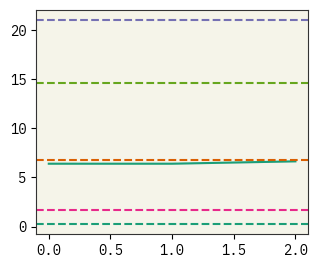

In [8]:
N = 2
M = 1
starts = np.random.randint(0, len(indexes), M)
plt.figure(figsize=(3.5, 3.5 / 1.2))
random_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="random",
        start_index=starts[i],
    )
    random_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C0", alpha=0.1)
# plot mean
random_points = np.array(random_points)
plt.plot(
    range(N + 1),
    random_points[:, :, 1].astype(float).mean(axis=0),
    color="C0",
    label="Random",
)

plt.axhline(y=raw_data[y_name].max(), color="C2", linestyle="--", label="max")
plt.axhline(y=raw_data[y_name].quantile(0.95), color="C4", linestyle="--", label="95%")
plt.axhline(y=raw_data[y_name].mean(), color="C1", linestyle="--", label="mean")
plt.axhline(y=raw_data[y_name].quantile(0.05), color="C3", linestyle="--", label="5%")
plt.axhline(y=raw_data[y_name].min(), color="C0", linestyle="--", label="min")

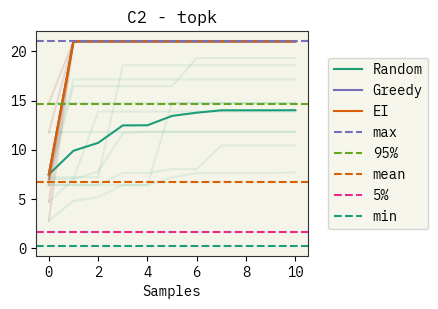

In [10]:
N = 10
M = 10
starts = np.random.randint(0, len(indexes), M)
plt.figure(figsize=(3.5, 3.5 / 1.2))

random_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="random",
        start_index=starts[i],
    )
    random_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C0", alpha=0.1)
# plot mean
random_points = np.array(random_points)
plt.plot(
    range(N + 1),
    random_points[:, :, 1].astype(float).mean(axis=0),
    color="C0",
    label="Random",
)

greedy_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="greedy",
        start_index=starts[i],
    )
    greedy_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C2", alpha=0.1)
# plot mean
greedy_points = np.array(greedy_points)
plt.plot(
    range(N + 1),
    greedy_points[:, :, 1].astype(float).mean(axis=0),
    color="C2",
    label="Greedy",
)

ei_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="expected_improvement",
        start_index=starts[i],
    )
    ei_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C1", alpha=0.1)
# plot mean
ei_points = np.array(ei_points)
plt.plot(
    range(N + 1), ei_points[:, :, 1].astype(float).mean(axis=0), color="C1", label="EI"
)

plt.axhline(y=raw_data[y_name].max(), color="C2", linestyle="--", label="max")
plt.axhline(y=raw_data[y_name].quantile(0.95), color="C4", linestyle="--", label="95%")
plt.axhline(y=raw_data[y_name].mean(), color="C1", linestyle="--", label="mean")
plt.axhline(y=raw_data[y_name].quantile(0.05), color="C3", linestyle="--", label="5%")
plt.axhline(y=raw_data[y_name].min(), color="C0", linestyle="--", label="min")
plt.xlabel("Samples")
# reduce number of ticks
# plt.xticks([0, 5, 10])
# plt.ylim(-10, 0)
# plt.yticks(np.linspace(-10, 0, 3))
plt.title("C2 - topk")
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
# plt.savefig("concept_multi.png", dpi=300)

In [ ]:
asktell.save_query("GPR_ada_embed_query.csv")

### IUPAC-Solubility

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(0)

data_path = "paper/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)
raw_data = raw_data.dropna()
raw_data = raw_data.sort_values(by=y_name)
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
# raw_data = raw_data.sample(frac=1).reset_index(drop=True)

print(raw_data.columns)

N = raw_data.shape[0]
indexes = [
    i for i in range(N)
]  # np.random.choice(raw_data.shape[0], int(N), replace=False)

print(len(raw_data), len(indexes))

# asktell = bolift.AskTellFewShotTopk(
#   prefix="",
#   prompt_template=PromptTemplate(
#       input_variables=["x", "y", "y_name"],
#       template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
#   ),
#   suffix="What is the {y_name} of {x}?@@@\nA:",
#   # x_formatter=lambda x: f"iupac name {x}",
#   y_name="measured log solubility in mols per litre",
#   y_formatter=lambda y: f"{y:.2f}",
#   model="text-curie-001",
#   selector_k=5,
# )

asktell = bolift.AskTellFinetuning(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    # x_formatter=lambda x: f"iupac name {x}",
    y_name="measured log solubility in mols per litre",
    y_formatter=lambda y: f"{y:.2f}",
    model="text-ada-001",
    id="ft-PKQqNUW5RDABzx0DzcXdmm7a",
    finetune=False,
    selector_k=5,
)

x_name = "IUPAC"
y_name = "measured log(solubility:mol/L)"

In [ ]:
N = 10
M = 5
starts = [i for i in range(M)]  # np.random.randint(0, len(indexes), M)
plt.figure(figsize=(3.5, 3.5 / 1.2))
random_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="random",
        start_index=starts[i],
    )
    random_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C0", alpha=0.1)
# plot mean
random_points = np.array(random_points)
plt.plot(
    range(N + 1),
    random_points[:, :, 1].astype(float).mean(axis=0),
    color="C0",
    label="Random",
)

greedy_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="greedy",
        start_index=starts[i],
    )
    greedy_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C2", alpha=0.1)
# plot mean
greedy_points = np.array(greedy_points)
plt.plot(
    range(N + 1),
    greedy_points[:, :, 1].astype(float).mean(axis=0),
    color="C2",
    label="Greedy",
)

ei_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="expected_improvement",
        start_index=starts[i],
    )
    ei_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C1", alpha=0.1)
# plot mean
ei_points = np.array(ei_points)
plt.plot(
    range(N + 1), ei_points[:, :, 1].astype(float).mean(axis=0), color="C1", label="EI"
)

plt.axhline(y=raw_data[y_name].max(), color="C2", linestyle="--", label="max")
plt.axhline(y=raw_data[y_name].quantile(0.95), color="C4", linestyle="--", label="95%")
plt.axhline(y=raw_data[y_name].mean(), color="C1", linestyle="--", label="mean")
plt.axhline(y=raw_data[y_name].quantile(0.05), color="C3", linestyle="--", label="5%")
plt.axhline(y=raw_data[y_name].min(), color="C0", linestyle="--", label="min")
plt.xlabel("Samples")
# reduce number of ticks
# plt.xticks([0, 5, 10])
# plt.ylim(-10, 0)
# plt.yticks(np.linspace(-10, 0, 3))
plt.title("IUPAC-Sol - topk")
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.savefig("concept_multi.png", dpi=300)